In [1]:
import torch
import mgplvm as mgp
import numpy as np
import matplotlib.pyplot as plt
import pickle
import time
import csv

np.random.seed(0)
torch.manual_seed(0)
print("torch.__version__",torch.__version__)
device = mgp.utils.get_device() # use GPU if available, otherwise CPU
#print(device)

loading
torch.__version__ 1.7.1+cu101


In [2]:
#mkdir -p data

In [10]:
time = 1000
neuron_num = 16
#head_data = np.loadtxt("spikehead16_5001d.csv", delimiter=",")[:,:time]
#traj = np.loadtxt("trjhead16_5001d.csv", delimiter=",")[:time]
#head_data = np.loadtxt("spikehead30_5001d.csv", delimiter=",")[:,:time]
#traj = np.loadtxt("trjhead30_5001d.csv", delimiter=",")[:time]
head_data = np.loadtxt("spikehead50_10001d.csv", delimiter=",")[:,:time]
traj = np.loadtxt("trjhead50_10001d.csv", delimiter=",")[:time]
print(traj.shape)
print(head_data.shape)

with open('data/fly_data.tsv', newline='') as csvfile:
    fly_data = np.array(list(csv.reader(csvfile, delimiter='\t')))
#Y = np.expand_dims(fly_data, 2).astype(float).transpose((2, 0, 1))
Y = np.expand_dims(head_data, 2).astype(float).transpose((2, 0, 1))
n_samples, n, m = Y.shape


(1000,)
(50, 1000)


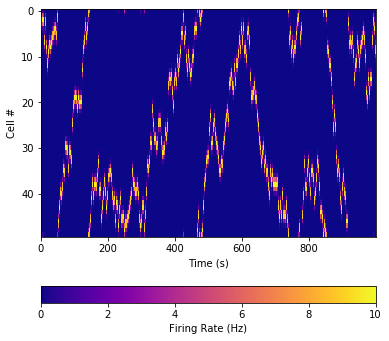

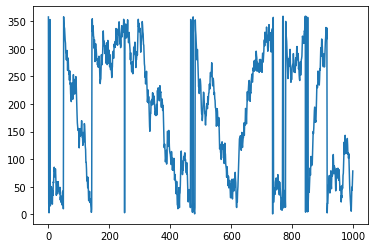

In [11]:
plt.figure(figsize = (6,6))
plt.imshow(head_data, cmap=plt.cm.plasma,aspect='auto')
plt.xlabel('Time (s)')
plt.ylabel('Cell #')
plt.colorbar(orientation='horizontal', label='Firing Rate (Hz)')
plt.clim(0, 10) 

plt.figure()
plt.plot(traj)

In [12]:
d = 1  # dims of latent space
n_z = 20  # number of inducing points 15
n_samples = 1  # number of samples
def build_model():
    # specify manifold, kernel and rdist
    manif = mgp.manifolds.Torus(m, d)  # latent distribution manifold
    lat_dist = mgp.rdist.ReLie(manif, m, n_samples)  # construct ReLie distribution
    # Note: we construct the kernel and likelihood by passing the data in for initialization
    kernel = mgp.kernels.QuadExp(
        n, manif.distance
    )  # Use an exponential quadratic (RBF) kernel
    lik = mgp.likelihoods.Gaussian(n)  # Gaussian likelihood
    #lprior = mgp.lpriors.Uniform(manif)  # Prior on the manifold distribution
    lprior = mgp.lpriors.Brownian(manif, fixed_brownian_c = True, fixed_brownian_eta = False, brownian_eta = torch.ones(d)*2**2)
    z = manif.inducing_points(n, n_z)  # build inducing points
    model = mgp.models.SvgpLvm(
        n, m, n_samples, z, kernel, lik, lat_dist, lprior, whiten=True
    ).to(device)
    return model

In [14]:
data = torch.tensor(Y, device=device, dtype=torch.get_default_dtype())
model = build_model()

#train_params = mgp.crossval.training_params(max_steps = 1000, n_mc = 16, lrate = 5e-2, print_every = 100, burnin = 50)
train_params = mgp.crossval.training_params(max_steps = 1000, n_mc = 26, lrate = 4e-2, print_every = 100, burnin = 50)
progress = mgp.crossval.train_model(model, data, train_params) # train model

iter   0 | elbo -6.389 | kl  0.002 | loss  6.389 | |mu| 0.112 | sig 1.500 | scale 1.000 | ell 2.000 | lik_sig 1.000 | brownian_c 0.000 | brownian_eta 4.000 |
iter 100 | elbo -2.056 | kl  0.012 | loss  2.066 | |mu| 1.254 | sig 0.546 | scale 0.858 | ell 1.970 | lik_sig 1.395 | brownian_c 0.000 | brownian_eta 1.082 |
iter 200 | elbo -1.859 | kl  0.025 | loss  1.884 | |mu| 1.418 | sig 0.159 | scale 0.781 | ell 1.399 | lik_sig 1.553 | brownian_c 0.000 | brownian_eta 0.324 |
iter 300 | elbo -1.613 | kl  0.048 | loss  1.661 | |mu| 1.427 | sig 0.056 | scale 0.743 | ell 0.780 | lik_sig 1.383 | brownian_c 0.000 | brownian_eta 0.363 |
iter 400 | elbo -1.336 | kl  0.076 | loss  1.412 | |mu| 1.454 | sig 0.013 | scale 0.700 | ell 0.451 | lik_sig 1.081 | brownian_c 0.000 | brownian_eta 0.377 |
iter 500 | elbo -1.106 | kl  0.091 | loss  1.197 | |mu| 1.462 | sig 0.007 | scale 0.660 | ell 0.360 | lik_sig 0.840 | brownian_c 0.000 | brownian_eta 0.381 |
iter 600 | elbo -0.954 | kl  0.096 | loss  1.050 | |

In [15]:
#%% plot tuning curves
"""query = torch.tensor(np.linspace(0, 2 * np.pi, 100),
                     dtype=torch.get_default_dtype(),
                     device=device)[None, None, ...]
data = torch.tensor(Y, dtype=torch.get_default_dtype()).to(device)
fmean, fvar = model.obs.predict(query, full_cov=False)
fstd = fvar.sqrt()

plt.figure(figsize=(8, 6))
for i in range(0, 16, 2):
    xs = query.cpu().numpy()
    mean, std = [arr.cpu().detach().numpy() for arr in [fmean, fstd]]
    xs = xs[0, 0, :]
    mean = mean[0, i, :]
    std = std[0, i, :]
    col = [0, i/16, 1-i/16]
    plt.plot(xs, mean, "-", color = col)
    plt.fill_between(xs, mean - 2 * std, mean + 2 * std, color=col, alpha=0.2)

plt.xlabel(r"$\theta$ [radian]")
plt.ylabel(r"rate [a.u.]")
plt.xlim(0, 2 * np.pi)
plt.xticks([0, np.pi, 2*np.pi], [r'$0$', r'$\pi$', r'$2\pi$'])
plt.show()
plt.close()"""

'query = torch.tensor(np.linspace(0, 2 * np.pi, 100),\n                     dtype=torch.get_default_dtype(),\n                     device=device)[None, None, ...]\ndata = torch.tensor(Y, dtype=torch.get_default_dtype()).to(device)\nfmean, fvar = model.obs.predict(query, full_cov=False)\nfstd = fvar.sqrt()\n\nplt.figure(figsize=(8, 6))\nfor i in range(0, 16, 2):\n    xs = query.cpu().numpy()\n    mean, std = [arr.cpu().detach().numpy() for arr in [fmean, fstd]]\n    xs = xs[0, 0, :]\n    mean = mean[0, i, :]\n    std = std[0, i, :]\n    col = [0, i/16, 1-i/16]\n    plt.plot(xs, mean, "-", color = col)\n    plt.fill_between(xs, mean - 2 * std, mean + 2 * std, color=col, alpha=0.2)\n\nplt.xlabel(r"$\theta$ [radian]")\nplt.ylabel(r"rate [a.u.]")\nplt.xlim(0, 2 * np.pi)\nplt.xticks([0, np.pi, 2*np.pi], [r\'$0$\', r\'$\\pi$\', r\'$2\\pi$\'])\nplt.show()\nplt.close()'

(1000,)


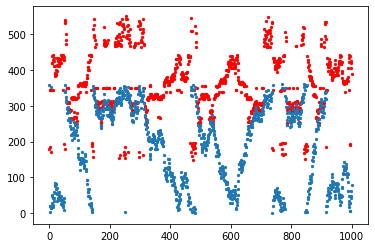

In [16]:
thetas = model.lat_dist.prms[0].detach().cpu().numpy()[0, :, 0] #% (2*np.pi) #mgplvm prediction
print(thetas.shape)
plt.figure()
offset = 320
plt.scatter(np.arange(time), thetas[:time]* (-20*np.pi)+offset, s=5,c="r")
plt.scatter(np.arange(time), traj[:time], s=5)

In [9]:
"""thetas = model.lat_dist.prms[0].detach().cpu().numpy()[0, :, 0] % (2*np.pi) #mgplvm prediction
plt.figure()
plt.scatter(np.arange(len(thetas)), thetas, marker = ".", color = "k", s = 100)
for i in range(len(thetas)-1):
  x1, x2 = thetas[i], thetas[i+1]
  if np.abs(x1-x2) < np.pi: plt.plot([i, i+1], [x1, x2], "k-")
plt.xlabel('time (a.u.)')
plt.ylabel(r'$\theta$')
plt.show()"""

'thetas = model.lat_dist.prms[0].detach().cpu().numpy()[0, :, 0] % (2*np.pi) #mgplvm prediction\nplt.figure()\nplt.scatter(np.arange(len(thetas)), thetas, marker = ".", color = "k", s = 100)\nfor i in range(len(thetas)-1):\n  x1, x2 = thetas[i], thetas[i+1]\n  if np.abs(x1-x2) < np.pi: plt.plot([i, i+1], [x1, x2], "k-")\nplt.xlabel(\'time (a.u.)\')\nplt.ylabel(r\'$\theta$\')\nplt.show()'